<a href="https://colab.research.google.com/github/Da-Woon-Kim/DeepLearning/blob/main/%EA%B0%9C%EC%9D%B8%EA%B3%BC%EC%A0%9C_%EC%A0%84%EB%A0%A5%EB%9F%89%EC%98%88%EC%B8%A1_DawoonKim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dacon 대회의 전력 예측량 구하기
- 이 대회는 시계열 데이터인 train, test 파일을 제공하고, train파일로 훈련을 적용시킨 뒤 test데이터를 예측하는 대회이다.
- 이 대회의 심사 기준점은 SMAPE라는 값을 도출 시켜 책정하는 방법이다. 따라서 loss 계산에 SMAPE를 대입하기로 한다.
- 진행 방향은 다음과 같다.  
  1. 데이터 불러오기  
    - 데이터 csv파일 불러오기
    - 결측치 존재할 경우 결측치 대체
    - 연관이 있을 수 있는 변수 생성
  2. EDA
    - 시간에 관련된 변수를 생성
    - 주중, 주말로 나눈 변수를 생성
    - 건물 및 시간에 따른 전력량 비교
  3. 비슷한 패턴을 가진 건물 그룹화
    - Self-Organize Mapping 방법을 이용해 진행
    - 처음 데이터에 clustering 결과를 병합 및 다음 필요한 데이터 형태로 변형
  4. 모델링
    - LSTM 
      - active function = RELU를 이용한 모델링 및 트레이닝 진행
      - 예측값 생성
      - active function = MISH를 이용한 모델링 및 트레이닝 진행
      - 예측값 생성
  5. 결과 비교
    - 원본과 두 가지 방법으로 예측한 값을 그래프로 비교
  6. 고찰
    - 의도한 진행방향
    - 의의
    - 한계점



## 1. 데이터 불러오기 및 결측치 채우기

In [1]:
# 기본 모듈
import pandas as pd
import numpy as np
import os
import math
import sys

# for문 등 소요 시간을 나타내주는 모듈
import time
from tqdm import tqdm

# System
from ipywidgets import interact
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# train2.csv 구글 드라이브에 업데이트

# from google.colab import files
# myfile = files.upload()

In [3]:
# 구글 드라이브 불러오기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 데이터 column 영어로 변경
elec_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

# 데이터 불러오기
elec_init = pd.read_csv("/content/drive/MyDrive/train2.csv",names=elec_col,header=0,parse_dates=['date_time'])
test_init = pd.read_csv("/content/drive/MyDrive/test2.csv",names=test_col,header=0,parse_dates=['date_time'])
mise = pd.read_csv("/content/drive/MyDrive/미세먼지PM10.csv",names=['date_time','PM10'],header=0,parse_dates=['date_time'])

# 데이터의 앞부분 확인
elec_init.head()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0,0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0,0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0,0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0,0


In [5]:
# 데이터의 뒷 부분 확인
elec_init.tail()

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1,1
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1,1
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1,1
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1,1
122399,60,2020-08-24 23:00:00,3204.576,27.1,2.6,75.0,0.0,0.0,1,1


In [6]:
# test data 확인
test_init.head()

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- 기온,풍속,습도,일조량은 3시간 마다 한번씩 데이터가 주어져있고, 강수량은 6시간마다 한번씩 데이터가 주어져있다.
- 따라서 데이터가 없는 칸에는 이전에 데이터가 있는 값으로 대치 해 주었다.
- 비전기냉방과 태양광보유 여부는 미보유시 결측치가 생겨있다.
- 따라서 미보유시 0 값을 넣어줌으로써 없는 값을 채워준다.

In [7]:
# 미세먼지 데이터 추가
test = pd.merge(test_init,mise,left_on="date_time",right_on='date_time',how='left')

# test data NaN = 0 처리
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)
test["cooler"].iloc[test["cooler"].isnull()==True] = 0
test["solar"].iloc[test["solar"].isnull()==True] = 0

# 미세먼지 결측값 ; linear방법을 사용해 결측값을 대치
test['PM10'] = test['PM10'].interpolate(method='linear')
test

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar,PM10
0,1,2020-08-25 00:00:00,27.8,1.5,74.0,0.0,0.0,0.0,0.0,46.0
1,1,2020-08-25 01:00:00,27.6,1.4,75.3,0.0,0.0,0.0,0.0,57.0
2,1,2020-08-25 02:00:00,27.5,1.2,76.7,0.0,0.0,0.0,0.0,60.0
3,1,2020-08-25 03:00:00,27.3,1.1,78.0,0.0,0.0,0.0,0.0,56.0
4,1,2020-08-25 04:00:00,26.9,1.2,79.7,0.0,0.0,0.0,0.0,44.0
...,...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19:00:00,28.6,3.6,66.0,0.0,0.5,0.0,0.0,10.0
10076,60,2020-08-31 20:00:00,28.3,3.8,67.0,0.0,0.3,0.0,0.0,5.0
10077,60,2020-08-31 21:00:00,27.9,4.1,68.0,0.0,0.0,1.0,1.0,4.0
10078,60,2020-08-31 22:00:00,27.9,4.1,68.0,0.0,0.0,0.0,0.0,4.0


- 불쾌지수는 날씨에 관련된 생성할 수 있는 변수이다.
- 2020년 까지 미세먼지에 관한 이슈가 있었다. 따라서 추가 해 보기로 한다.
- 이를 계산해 전력량 예측에 추가해 보기로 한다.

In [8]:
# 불쾌지수 추가
elec_init['bad'] = 1.8*elec_init['temp'] - 0.55*(1-(elec_init['humid']/100))*(1.8*elec_init['temp']-26) + 32
test['bad'] = 1.8*test['temp'] - 0.55*(1-(test['humid']/100))*(1.8*test['temp']-26) + 32

# 미세먼지 데이터 추가
elec = pd.merge(elec_init,mise,left_on="date_time",right_on='date_time',how='left')

# 미세먼지 결측값 ; linear방법을 사용해 결측값을 대치
elec['PM10'] = elec['PM10'].interpolate(method='linear')
elec

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,bad,PM10
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,63.43008,25.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,63.56993,17.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,63.22775,10.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,62.54339,9.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,62.39760,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1,1,77.80896,43.0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1,1,77.44917,73.0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1,1,77.44917,60.0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1,1,77.52246,48.0


## 2. 데이터 EDA
- 이 파트에서는 다음과 같이 실행한다.
  - 기본적인 데이터 분포를 확인한다.
  - 건물별로 확인한다.
    - 시간대별 전력사용량 그래프를 그려 비교한다.
  - 주중, 주말로 나누어 전력 사용량을 비교한다.

In [9]:
!apt-get update -qq
!apt-get install fonts-nanum* -qq

In [10]:
import matplotlib.font_manager as fm
fm._rebuild()

In [11]:
# 시각화에 필요한 패키지 로딩
from matplotlib import pyplot as plt
from matplotlib import font_manager,rc
import seaborn as sns

# 그래프 한글 폰트 가져오기
from matplotlib import font_manager, rc
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

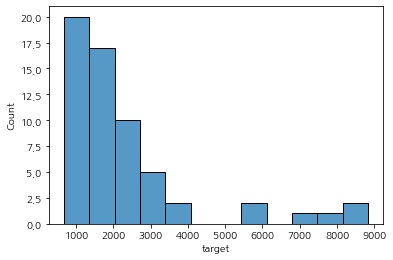

In [12]:
sns.histplot(elec.groupby('num')['target'].mean())

- 건물마다 전력 사용량 평균이 다양하게 이루어져 있다.

In [13]:
# 시간 뽑는 모듈 설치
from datetime import datetime

In [14]:
# 시간에 관련된 변수 뽑기
def make_time(train):
    train['date_time'] = pd.to_datetime(train.date_time)
    
    train['month'] = train.date_time.dt.month                    # 월(숫자)
    train['day'] = train.date_time.dt.day                        # 일(숫자)
    train['hour'] = train.date_time.dt.hour                      # 시(숫자)
    train['weekday'] = train.date_time.dt.weekday                # 요일(숫자)
    train['dayofyear'] = train.date_time.dt.dayofyear            # 연 기준 몇일째(숫자)
    
    return train

In [15]:
# 주말 여부
def weekend(x):
    if x.dayofweek in [5, 6]:
        return 1
    else: 
        return 0

In [16]:
# 데이터에 각각 월 일 시간 요일 일수 주말여부 대입
elec = make_time(elec)
test = make_time(test)
elec['weekend'] = elec['date_time'].apply(weekend)
test['weekend'] = test['date_time'].apply(weekend)

In [17]:
# 현충일, 광복절이 각각 토요일이므로 대체공휴일인 월요일 또한 휴일로 지정
elec['weekday'][elec['dayofyear'] == 160] = 1
elec['weekday'][elec['dayofyear'] == 230] = 1

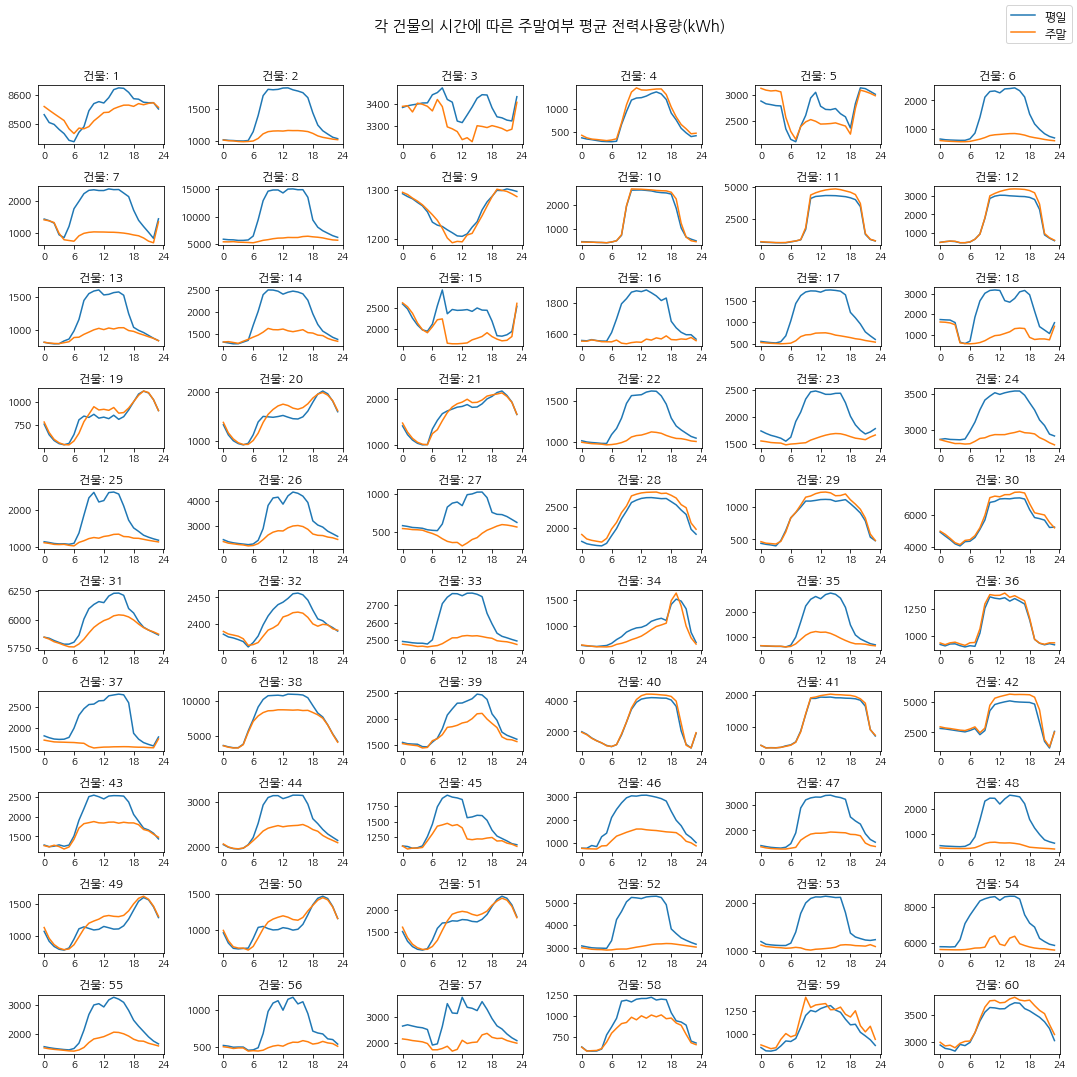

In [18]:
# 시간 + 요일별 평균 전력 사용량
fig = plt.figure(figsize = (15 ,15))
plt.title("각 건물의 시간에 따른 주말여부 평균 전력사용량(kWh)", fontsize=15, y=1.05)
plt.axis('off')

for num in range(1,61):
    df = elec[elec.num==num]
    ax = fig.add_subplot(10,6,num)
    ax.plot(df['hour'].unique(), df[df.weekend==0].groupby('hour')['target'].mean(), label='평일')
    ax.plot(df['hour'].unique(), df[df.weekend==1].groupby('hour')['target'].mean(), label='주말')
    ax.set_title(f'건물: {num}')
    ax.set_xticks([0,6,12,18,24])
lines, labels = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, labels, loc = 1, prop={'size':12})
plt.tight_layout()
plt.show()

- 건물에 따라 그래프의 형태가 비슷하게 진행되는 그래프가 존재한다.
- 따라서 이 건물들을 같은 종류로 묶기 위해서 Self-Organize Map을 이용해 군집을 형성하기로 한다.

# 3. 군집화 형성
- SOM방법으로 군집을 형성한다.
- 군집 형성 후 묶인 건물별로 전력사용량, 온도, 습도 등 평균을 계산해 군집화 시킨다.

In [19]:
!pip install tslearn
!pip install minisom

In [20]:
#Clustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from minisom import MiniSom

In [21]:
## 시계열 군집화용 DataFrame을 생성하는 함수 (row->num, col->date_time)
def cluster_df(train,scaler=StandardScaler()): # scaler=[False, 'MinMaxScaler()', 'StandardScaler()']
    train_ = train.copy()
    
    # NaN값을 0으로 처리해주는 함수 pivot_table
    train_ts = train_.pivot_table(values='target', index=train_.num, columns='date_time', aggfunc='first')
    
    # 변환이 존재할 경우 이 부분을 진행 (최대-최소변환, 정규변환)
    if scaler:
        train_ts_T = scaler.fit_transform(train_ts.T)
        train_ts = pd.DataFrame(train_ts_T.T, index=train_ts.index, columns=train_ts.columns)
    
    return train_ts

In [22]:
# SOM 알고리즘 결과를 정리해주는 DataFrame을 생성하는 함수
def make_som_df(X):

    # win_map() : 두 값을 비교해 더 큰 쪽의 값을 출력해주는 함수
    win_map = som.win_map(X)

    som_result = []
    for i in range(60):
        som_result.append([i+1, som.winner(X[i])])
    som_df = pd.DataFrame(som_result, columns=['num','cluster'])
    return som_df

In [23]:
# 제시 되어 있는 데이터를 대입해 그룹을 출력
elec_ts = cluster_df(elec,scaler=StandardScaler())
X = elec_ts.values

som = MiniSom(x=2, y=3, input_len = X.shape[1])
som.random_weights_init(X)
som.train(data=X, num_iteration=50000)

som_df = make_som_df(X)

In [24]:
# 분류 된 군집을 나타낸다.
clus = som_df['cluster'].unique()
clus

array([(1, 2), (1, 0), (0, 1), (0, 2), (1, 1), (0, 0)], dtype=object)

In [25]:
## 클러스터 별 시간&요일별 전력사용량 평균 시각화
def visualize_by_cluster(train,df_with_labels, n_cluster, algorithm):
    fig = plt.figure(figsize = (20 ,4*n_cluster))
    plt.title('군집 수가 {}개일 때 각 군집별 시계열분포'.format(n_cluster), fontsize=15, y=1.05)
    plt.axis('off')
    
    if algorithm=='kmeans':
        labels = df_with_labels['cluster(n={})'.format(n_cluster)]
    elif algorithm=='som':
        labels = df_with_labels.cluster
    
    idx=1
    for label in set(labels): # 각 군집에 대해
        
        if algorithm=='kmeans':
            df = train[train.num.isin(list(labels[labels==label].keys()))]
        elif algorithm=='som':
            df = train[train.num.isin(som_df[som_df.cluster==label].num.values)]
        
        hour = df.hour.unique()
        weekday = df.weekday.unique()
        
        ### x축: 시간 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 시간별 평균 전력사용량'.format(label))
        ax.set_xticks(hour)
        for num in df.num.unique():
            df_one = df[df.num==num]
            sns.lineplot(x=hour, y=df_one.groupby('hour')['target'].mean(), color='grey', alpha=0.3)
        sns.lineplot(x=hour, y=df.groupby('hour')['target'].mean(), color='red')
        
        ### x축: 요일 ###
        ax = fig.add_subplot(n_cluster,2, idx); idx+=1
        ax.set(title='{}번 군집의 요일별 평균 전력사용량'.format(label))
        for num in df.num.unique():
            df_one = df[df.num==num]
            df_one_counts = df_one.groupby('weekday')['target'].mean()
            df_one_counts = df_one_counts.reindex(weekday)
            sns.lineplot(x=weekday, y=df_one_counts, color='grey', alpha=0.3)
        df_counts = df.groupby('weekday')['target'].mean()
        df_counts = df_counts.reindex(weekday)
        sns.pointplot(x=weekday, y=df_counts, color='red')
        ax.legend(['총 {}개 건물'.format(df.num.nunique())], loc=1)

    plt.show()

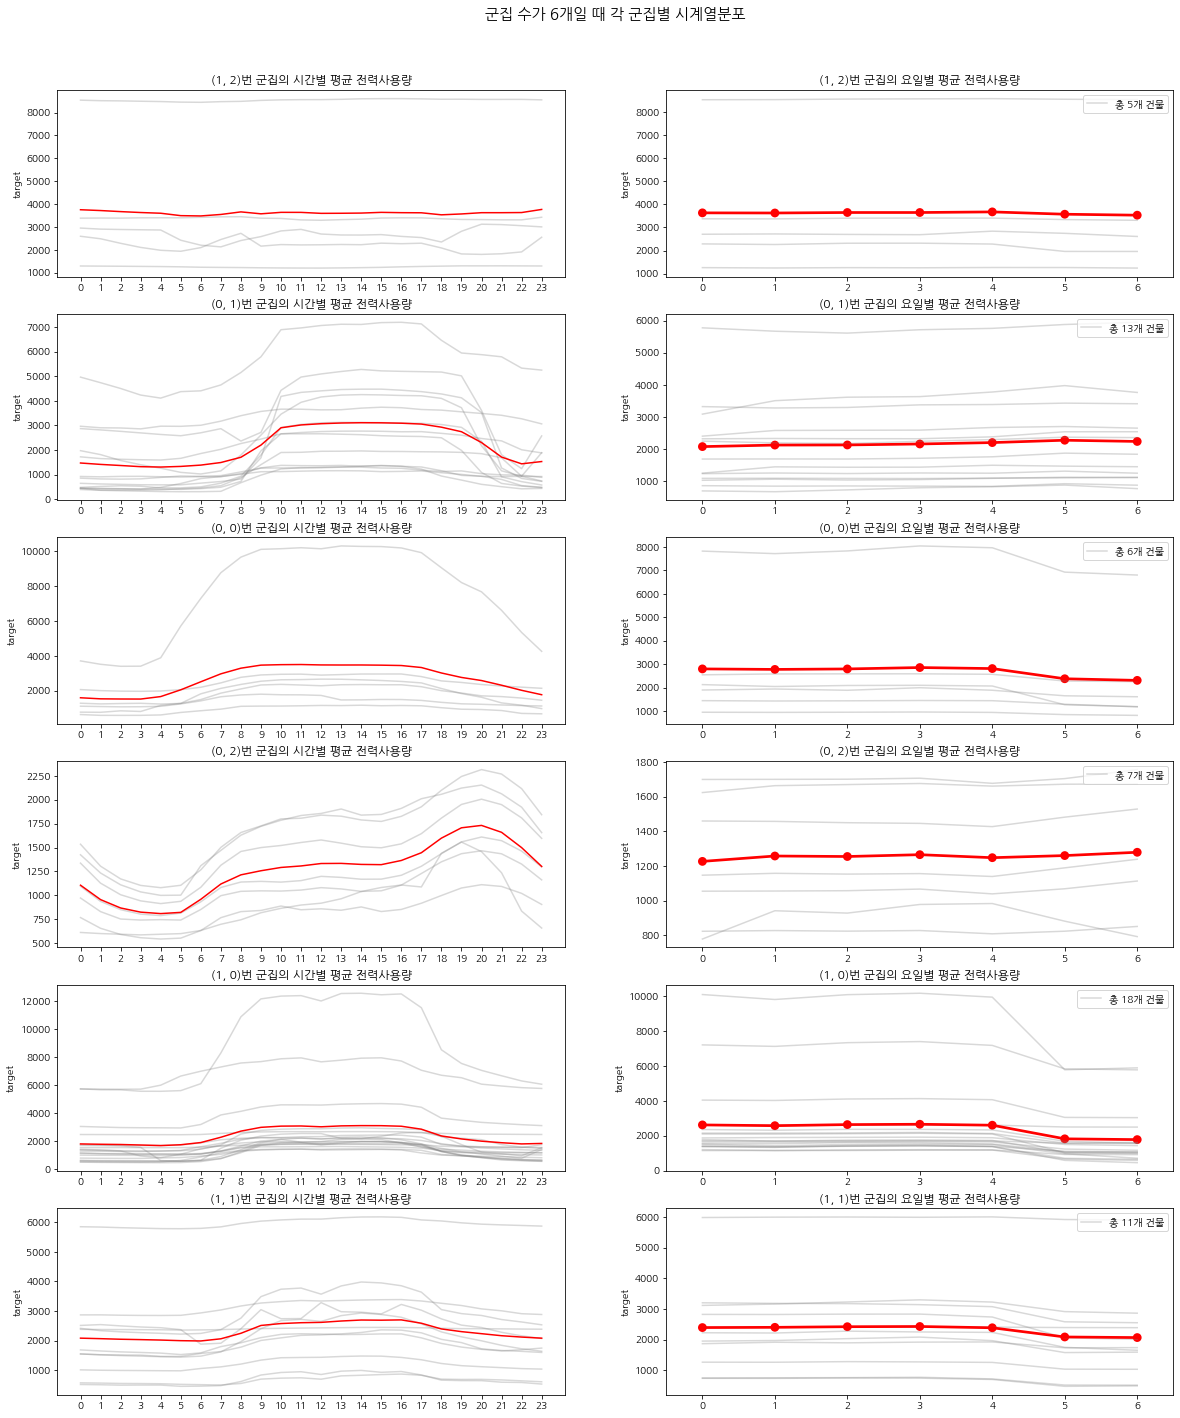

In [26]:
# 군집별 시각화
visualize_by_cluster(elec,som_df, 6, algorithm='som')

- 군집의 개수를 조사해보니 6개의 군집으로 나누어졌다.
- 데이터를 6개의 군집에 맞춰 조작하기로 한다.

In [27]:
# 클러스터링 넘버 통합
elec_join = pd.merge(elec, som_df, left_on='num', right_on='num', how='outer')
elec_join

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar,bad,PM10,month,day,hour,weekday,dayofyear,weekend,cluster
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0,63.43008,25.0,6,1,0,0,153,0,"(1, 2)"
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0,0,63.56993,17.0,6,1,1,0,153,0,"(1, 2)"
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0,0,63.22775,10.0,6,1,2,0,153,0,"(1, 2)"
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0,0,62.54339,9.0,6,1,3,0,153,0,"(1, 2)"
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0,0,62.39760,13.0,6,1,4,0,153,0,"(1, 2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1,1,77.80896,43.0,8,24,19,0,237,0,"(0, 1)"
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1,1,77.44917,73.0,8,24,20,0,237,0,"(0, 1)"
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1,1,77.44917,60.0,8,24,21,0,237,0,"(0, 1)"
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1,1,77.52246,48.0,8,24,22,0,237,0,"(0, 1)"


In [28]:
# 불 필요한 변수를 제외하고 받아들임
elec_split = elec_join.iloc[:,[1,2,3,4,5,6,7,10,11,17,18]]
elec_split

# cluster 그룹별로 mean값 생성
elec_mean = elec_split.groupby(['cluster','date_time'], as_index=False).mean()
elec_mean

,cluster,date_time,target,temp,wind,humid,rain,sunny,bad,PM10,weekend
0,"(0, 0)",2020-06-01 00:00:00,1367.010000,18.333333,2.033333,88.333333,0.583333,0.00,64.422023,25.0,0
1,"(0, 0)",2020-06-01 01:00:00,1335.924000,17.950000,2.300000,92.000000,0.166667,0.00,64.025925,17.0,0
2,"(0, 0)",2020-06-01 02:00:00,1331.889000,17.816667,2.616667,92.666667,0.016667,0.00,63.824902,10.0,0
3,"(0, 0)",2020-06-01 03:00:00,1315.881000,17.516667,2.466667,93.333333,0.083333,0.00,63.330313,9.0,0
4,"(0, 0)",2020-06-01 04:00:00,1466.553000,17.450000,2.500000,93.833333,0.000000,0.00,63.231213,13.0,0
...,...,...,...,...,...,...,...,...,...,...,...
12235,"(1, 2)",2020-08-24 19:00:00,3822.156196,28.780000,1.540000,74.000000,0.000000,0.46,80.081754,43.0,0
12236,"(1, 2)",2020-08-24 20:00:00,3832.538091,27.820000,0.920000,78.800000,0.000000,0.00,79.239870,73.0,0
12237,"(1, 2)",2020-08-24 21:00:00,3876.802359,27.480000,0.700000,81.200000,0.000000,0.00,79.012914,60.0,0
12238,"(1, 2)",2020-08-24 22:00:00,3862.495298,27.060000,0.800000,83.200000,0.000000,0.00,78.549272,48.0,0


- 위와 같이 데이터를 구해낼 수 있다.
- 건물 집단의 특징을 비교해보면
  - (1,2)번 군집: 6시~18시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
  - (0,1)번 군집: 8시~20시까지 전력사용량이 많고, 주말과 평일의 전력사용량이 비슷한 건물들
  - (0,0)번 군집: 저녁 시간대에 전력사용량이 많은 건물들
  - (0,2)번 군집: 이른 아침부터 저녁까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들
  - (1,0)번 군집: 시간별 전력사용량의 차이가 크지 않고, 주말과 평일의 전력사용량이 비슷한 건물들
  - (1,1)번 군집: 8시~20시까지 전력사용량이 많고, 주말보다 평일의 전력사용량이 많은 건물들  
로 확인할 수 있었다.  

# 4. 모델 LSTM 적용
- 가공된 train data를 가지고 훈련과 예측을 적용해 보기로 한다.
- 첫 번째로 active function을 RELU를 적용하기로 한다.
- 두 번째는 active function을 MISH를 적용하기로 한다.
- MISH는 tanh(softplus(x))를 이용해 만든 것이다.

In [41]:
# LSTM에 이용할 모듈 불러오기
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import get_custom_objects

In [42]:
# Custom Loss Function
import keras.backend as K

def SMAPE(true,predicted):
    epsilon = 0.1
    summ = K.maximum(K.abs(true) + K.abs(predicted) + epsilon, 0.5 + epsilon)
    smape = K.abs(predicted - true) / summ * 2.0
    return smape

In [31]:
# 시간 순서대로 정렬 ( 시계열 데이터 예측이기 때문에 랜덤성을 부여해서는 안된다. )
elec_sort = elec_mean.sort_values(['date_time','cluster'])

# 변수 순서 정렬
elec_sort = elec_sort[['cluster','date_time','temp','wind','humid','rain','sunny','weekend','bad','PM10','target']]
elec_sort

,cluster,date_time,temp,wind,humid,rain,sunny,weekend,bad,PM10,target
0,"(0, 0)",2020-06-01 00:00:00,18.333333,2.033333,88.333333,0.583333,0.0,0,64.422023,25.0,1367.010000
2040,"(0, 1)",2020-06-01 00:00:00,18.646154,1.984615,90.307692,0.107692,0.0,0,65.032970,25.0,1365.950077
4080,"(0, 2)",2020-06-01 00:00:00,17.800000,2.500000,92.571429,0.571429,0.0,0,63.796051,25.0,928.090286
6120,"(1, 0)",2020-06-01 00:00:00,18.122222,1.855556,89.555556,0.433333,0.0,0,64.152256,25.0,1613.499500
8160,"(1, 1)",2020-06-01 00:00:00,18.672727,1.818182,86.727273,0.345455,0.0,0,64.963259,25.0,1848.270273
...,...,...,...,...,...,...,...,...,...,...,...
4079,"(0, 1)",2020-08-24 23:00:00,27.053846,1.915385,82.923077,0.000000,0.0,0,78.515775,33.0,1765.053692
6119,"(0, 2)",2020-08-24 23:00:00,27.700000,2.042857,77.000000,0.000000,0.0,0,78.802110,33.0,1582.495500
8159,"(1, 0)",2020-08-24 23:00:00,27.227778,1.255556,81.055556,0.000000,0.0,0,78.598391,33.0,2032.293912
10199,"(1, 1)",2020-08-24 23:00:00,26.909091,1.027273,85.000000,0.000000,0.0,0,78.521284,33.0,2335.559683


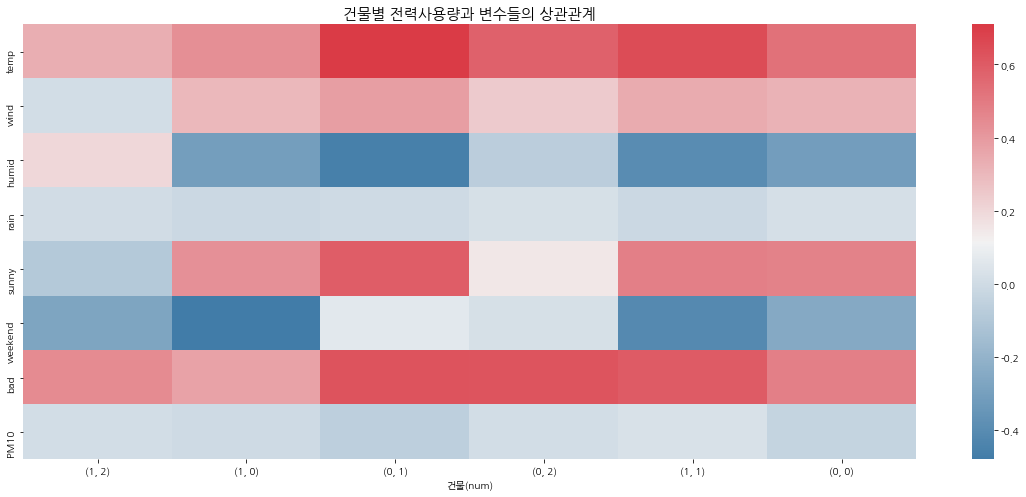

In [32]:
# 클러스터 별 변수와의 상관관계 heatmap
corr = []
for num in clus:
    df = elec_sort[elec_sort['cluster']==num]
    num_corr = df.corr()['target']
    num_corr = num_corr.drop(['target'])
    corr.append(num_corr)
corr_df = pd.concat(corr, axis=1).T
corr_df.index = list(clus)

# 시각화
f, ax = plt.subplots(figsize=(20,8))
plt.title("건물별 전력사용량과 변수들의 상관관계", fontsize=15)
sns.heatmap(corr_df.T, cmap=sns.diverging_palette(240,10,as_cmap=True), ax=ax)
plt.xlabel('건물(num)')
plt.show()

- 건물의 클러스터링마다 다른 상관관계를 가짐을 확인할 수 있었다.
- 이를 따로 예측하기 위해서 클러스터링 넘버에 맞게 모델링을 하기로 결정했다.

### 4-1. RELU를 이용하여 적용

In [33]:
#Modeling
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout

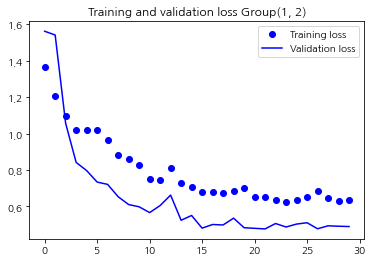

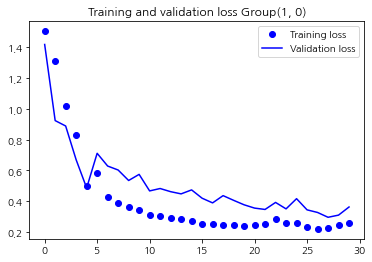

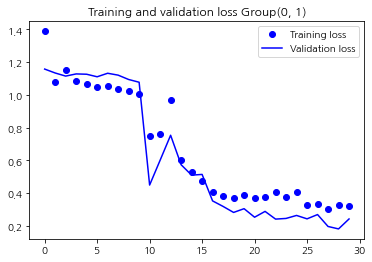

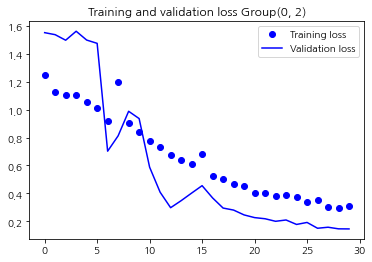

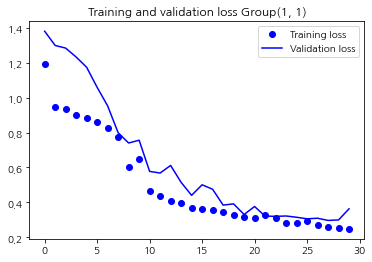

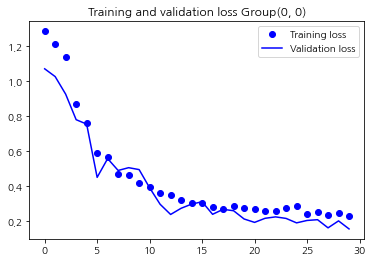

In [34]:
# 건물별 모델 및 예측 결과 저장
model_history = {}
forecast_future = {}
predict_past = {}

# 모델 training
j = 0
for num in tqdm(clus):

    # 집단의 넘버 생성
    j=j+1

    # 피처 골라내서 데이터프레임 만들기
    train_num1 = elec_sort[elec_sort['cluster']==num]
    train_num1_corr = train_num1.corr()['target']
    variables = train_num1_corr[abs(train_num1_corr)>0.3].keys().tolist()
    train_num1 = train_num1[variables]
    
    
    # 정규화
    if train_num1.shape[1]>1:
        feature_scaler = MinMaxScaler()
        train_num1.iloc[:,:-1] = feature_scaler.fit_transform(train_num1.iloc[:,:-1])

    y_scaler = StandardScaler()
    y_scaler2 = y_scaler.fit(train_num1[['target']])
    train_num1['target'] = y_scaler2.transform(train_num1[['target']])

    train_num1 = train_num1.values

    # 시계열 데이터 만들기
    train_X = []
    train_y = []

    n_future = 1
    n_past = 24 ## 24시간 전의 데이터까지 고려

    for i in range(n_past, len(train_num1)-n_future+1):
        train_X.append(train_num1[i-n_past:i, 0:train_num1.shape[1]])
        train_y.append(train_num1[i+n_future-1:i+n_future, -1])
    train_X, train_y = np.array(train_X), np.array(train_y)

    # 모델 형성
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(train_y.shape[1]))
    model.compile(optimizer='adam', loss=SMAPE)

    # 모델 학습
    history = model.fit(train_X, train_y, epochs=30, batch_size=128, validation_split=0.1, verbose=0, shuffle=False)
    model_history['num{}'.format(j)] = history
    
    # 학습데이터 예측
    predict_train = model.predict(train_X)
    k2 = predict_train.copy()
    predict_train = y_scaler2.inverse_transform(predict_train)
    predict_train = predict_train[:,0]
    predict_past['num{}'.format(j)] = predict_train

    # loss graph
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss Group{}'.format(num))
    plt.legend()

    plt.show()

- loss graph를 확인했을 때 그룹 (1,0)의 loss가 가장 위태하지만 대부분 잘 안정적으로 train이 되는 것을 확인할 수 있었다.

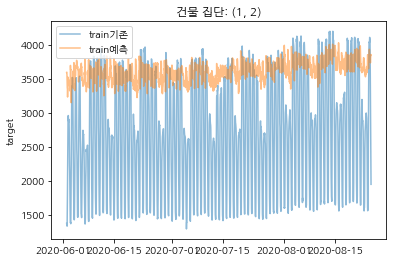

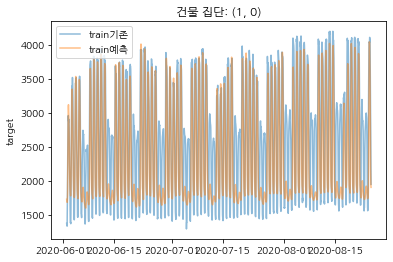

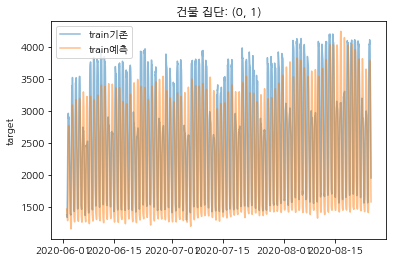

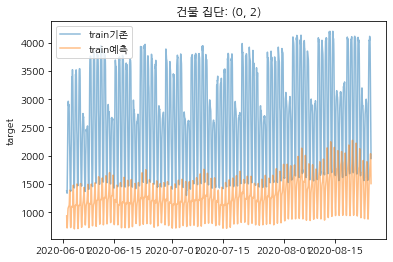

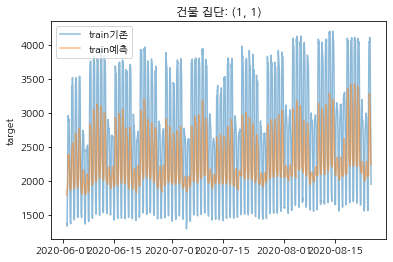

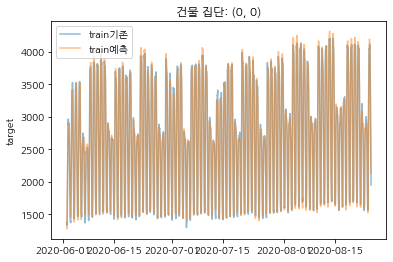

In [35]:
for k in tqdm(range(1,7)):
    train_dates = elec_sort.date_time.unique()[24:]
    predict_train = predict_past['num{}'.format(k)]
    
    ax = sns.lineplot(x=train_dates, y=elec_sort[elec_sort['cluster']==elec_sort['cluster'][0]]['target'][24:], alpha=0.5, label='train기존')
    sns.lineplot(x=train_dates, y=predict_train, alpha=0.5, label='train예측')
    ax.set_title(f'건물 집단: {str(clus[k-1])}') 
    plt.show()

- 대체적으로 건물 (0,0) 집단이 가장 예측력이 좋았다.
- 구체적으로 진행을 해 봐야 알겠지만 실제 값과 유사하게 진행되는 집단(1,0) , (0,1), (0,0) 세 집단이 있다.




## 4-2. MISH를 이용하여 적용

In [43]:
# Mish function in get custom objects
class Mish(Activation):
    def __init__(self, activation, **kwargs):
        super(Mish, self).__init__(activation, **kwargs)
        self.__name__ = 'Mish'

def mish(x):
    return x * K.tanh(K.softplus(x))

get_custom_objects().update({'mish': Mish(mish)})

- 이 부분은 LSTM 모듈 부분과 MISH 부분을 교차로 두번 실행 시켜야 아래 training이 진행이 됩니다.

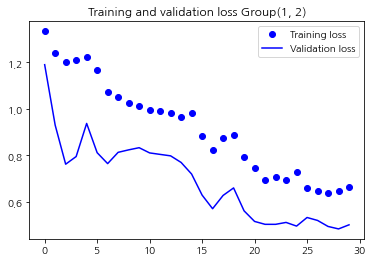

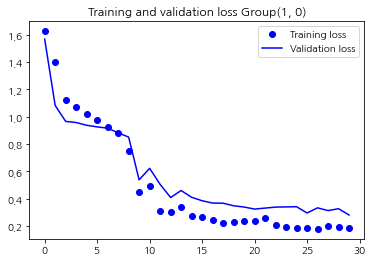

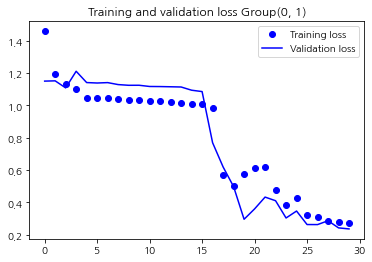

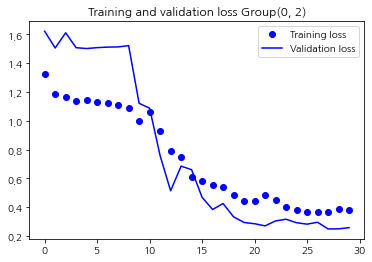

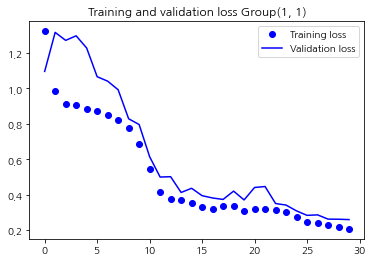

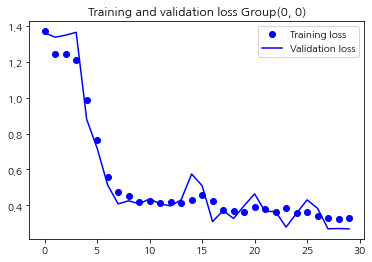

In [44]:
# 건물별 모델 및 예측 결과 저장
model_history = {}
forecast_future = {}
predict_past2 = {}

# 모델 training
j = 0
for num in tqdm(clus):

    # 집단의 넘버 생성
    j=j+1

    # 피처 골라내서 데이터프레임 만들기
    train_num1 = elec_sort[elec_sort['cluster']==num]
    train_num1_corr = train_num1.corr()['target']
    variables = train_num1_corr[abs(train_num1_corr)>0.3].keys().tolist()
    train_num1 = train_num1[variables]
    
    
    # 정규화
    if train_num1.shape[1]>1:
        feature_scaler = MinMaxScaler()
        train_num1.iloc[:,:-1] = feature_scaler.fit_transform(train_num1.iloc[:,:-1])

    y_scaler = StandardScaler()
    y_scaler2 = y_scaler.fit(train_num1[['target']])
    train_num1['target'] = y_scaler2.transform(train_num1[['target']])

    train_num1 = train_num1.values

    # 시계열 데이터 만들기
    train_X = []
    train_y = []

    n_future = 1
    n_past = 24 ## 24시간 전의 데이터까지 고려

    for i in range(n_past, len(train_num1)-n_future+1):
        train_X.append(train_num1[i-n_past:i, 0:train_num1.shape[1]])
        train_y.append(train_num1[i+n_future-1:i+n_future, -1])
    train_X, train_y = np.array(train_X), np.array(train_y)

    # 모델 형성
    model = Sequential()
    model.add(LSTM(64, activation='mish', input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
    model.add(LSTM(32, activation='mish', return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(train_y.shape[1]))
    model.compile(optimizer='adam', loss=SMAPE)

    # 모델 학습
    history = model.fit(train_X, train_y, epochs=30, batch_size=128, validation_split=0.1, verbose=0, shuffle=False)
    model_history['num{}'.format(j)] = history
    
    # 학습데이터 예측
    predict_train = model.predict(train_X)
    k2 = predict_train.copy()
    predict_train = y_scaler2.inverse_transform(predict_train)
    predict_train = predict_train[:,0]
    predict_past2['num{}'.format(j)] = predict_train

    # loss graph
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss Group{}'.format(num))
    plt.legend()

    plt.show()

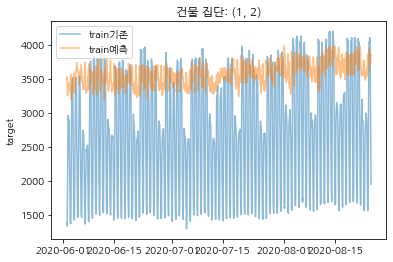

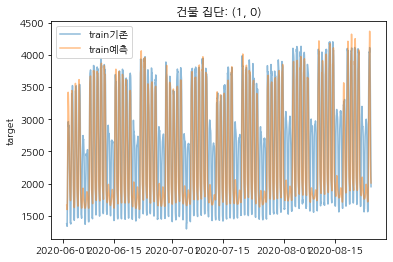

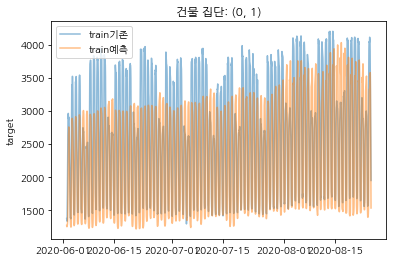

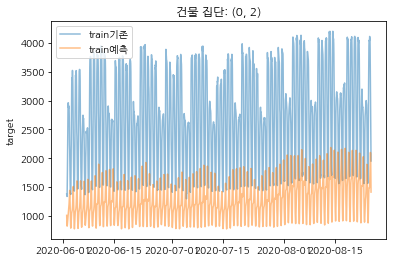

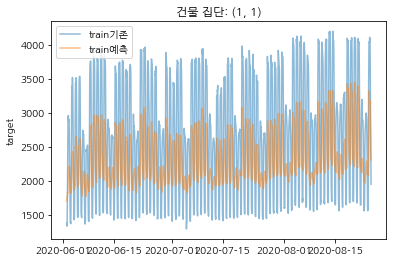

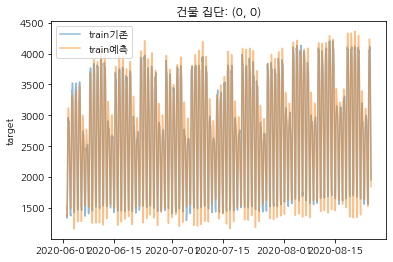

In [45]:
for k in tqdm(range(1,7)):
    train_dates = elec_sort.date_time.unique()[24:]
    predict_train2 = predict_past2['num{}'.format(k)]
    
    ax = sns.lineplot(x=train_dates, y=elec_sort[elec_sort['cluster']==elec_sort['cluster'][0]]['target'][24:], alpha=0.5, label='train기존')
    sns.lineplot(x=train_dates, y=predict_train2, alpha=0.5, label='train예측')
    ax.set_title(f'건물 집단: {str(clus[k-1])}') 
    plt.show()

- RELU를 이용한 예측값과 비슷한 형태를 보인다.
- (1,0)그룹은 더 정확하게 예측했지만, (0,1)그룹은 예측값이 떨어지는 형태를 보인다.

# 5. 그래프 결과 확인

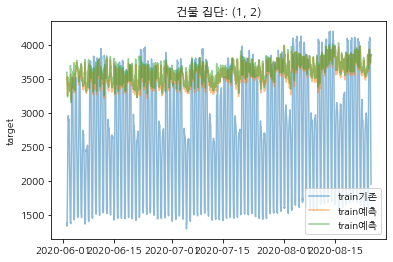

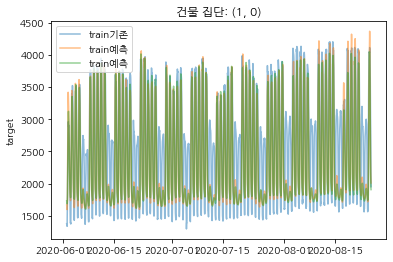

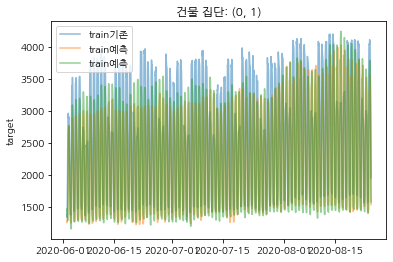

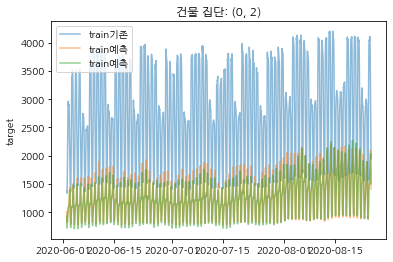

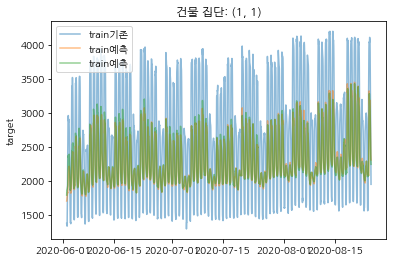

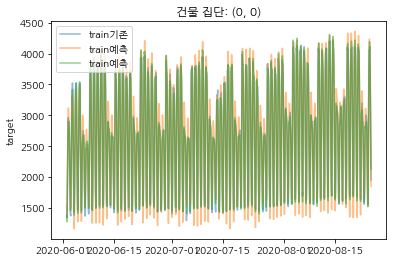

In [107]:
for k in tqdm(range(1,7)):
    train_dates = elec_sort.date_time.unique()[24:]
    predict_train = predict_past['num{}'.format(k)]
    predict_train2 = predict_past2['num{}'.format(k)]
    
    ax = sns.lineplot(x=train_dates, y=elec_sort[elec_sort['cluster']==elec_sort['cluster'][0]]['target'][24:], alpha=0.5, label='train기존')
    sns.lineplot(x=train_dates, y=predict_train2, alpha=0.5, label='train예측')
    sns.lineplot(x=train_dates, y=predict_train, alpha=0.5, label='train예측')
    ax.set_title(f'건물 집단: {str(clus[k-1])}') 
    plt.show()

- 그래프를 비교해 보면 중심 위치에서 변동이 작은 방법은 MISH를 사용하는 것이다.
- 예측 값은 두 active function이 비슷하게 이루어져 있다.
- (1,2), (0,2), (1,1) 그룹이 예측이 좋지 않았고 이외의 그룹에서는 예측값이 비교적 좋은 값을 나타냈다.

# 6. 고찰
- 의도한 계획
  - ARIMA모형을 사용해 예측해 보고 그 예측값과 LSTM에서 예측한 값을 비교 한다.
  - 비슷한 패턴을 보이는 건물끼리 묶고, 건물간의 차이는 regression등 평균값과 오차를 적용하여 예측한다.
  - 마지막으로 사용한 두 방법 중 한 가지를 선택 해 군집에 대입하여 예측하고, 전력량 평균의 차이를 가하면 예측값이 도출 될 것이다.
- 의의
  - 수업시간에 배운 LSTM을 사용해 볼 수 있는 기회가 되었다.
  - 시계열 데이터에 관한 방법을 찾아서 학습해 볼 수 있는 기회가 되었다.
  - 새로운 변수를 추가해서 상관성이 일부 있는 것을 관측할 수 있었다.
- 한계
  - 앞서 있었던 regression방법을 적용시키지 못해 건물 한 개의 단위로 측정하면 loss가 많이 생길 것이다.
  - 건물에 관한 데이터 혹은 지역에 관한 데이터가 존재했다면 더 많은 요소들을 고려하는 것이 가능 했을 것이다.
  - 지금 진행 했던 과정에서는 평균을 주로 사용했다. 이 값도 평균이 아닌 중앙값이나 대표할 수 있는 값으로 대신한다면 좀 더 정확히 예측할 수 있다.


